**Cost Sesitive Logisitic Regression**

**Team members:**

1. Akshitha Mandadi - AI19BTECH11001
2. Shreshta Thalapally - AI19BTECH11014
3. Koilada Yerni Jyotshna Sri - AI19BTECH11011

In [1]:
#all the necessary libraries are imported
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import normalize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils_data

from tqdm import tqdm

np.random.seed(0)
torch.random.manual_seed(0);

In [2]:
df = pd.read_csv("costsensitiveregression.csv")
df.head()

,NotCount,YesCount,ATPM,PFD,PFG,SFD,SFG,WP,WS,AH,AN,Status,FNC
0,2,21,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
1,23,0,0.0,0.044,0.0,0.0,0.0,0.306179,0.0,0.0,0.0,1,0.0
2,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0
3,5,18,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1,0.0
4,1,22,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0,0.0


In [3]:
#there are no null values in the data. Hence no processign is required for NaN values in the data
df.isnull().sum()

NotCount    0
YesCount    0
ATPM        0
PFD         0
PFG         0
SFD         0
SFG         0
WP          0
WS          0
AH          0
AN          0
Status      0
FNC         0
dtype: int64

In [4]:
df["Status"].value_counts()

0    103554
1     44082
Name: Status, dtype: int64

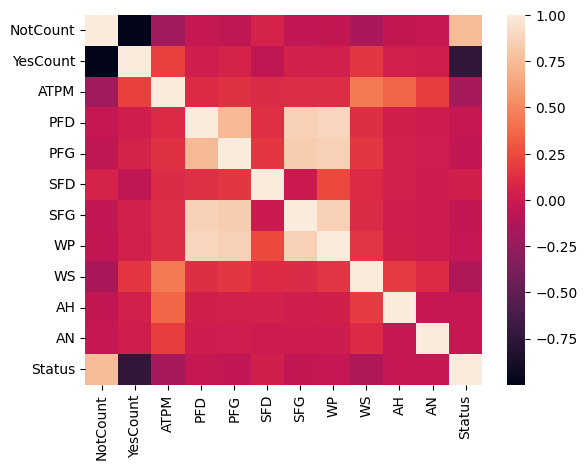

In [5]:
#plotting heatmap to make observations on correlation of data
sns.heatmap(df.iloc[:, :-1].corr("pearson"))
plt.show()

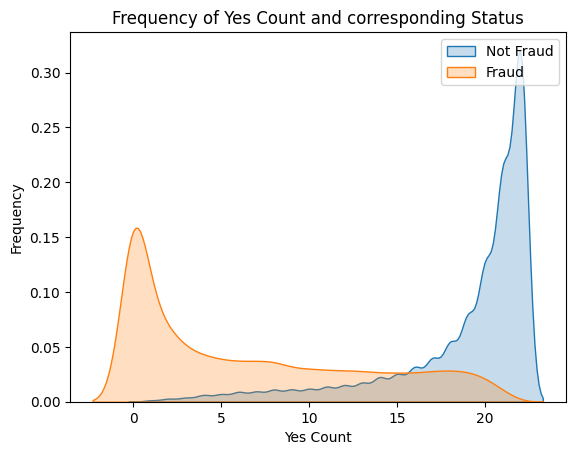

In [6]:
plot = sns.kdeplot(df["YesCount"][(df["Status"] == 0)], fill = True)
plot = sns.kdeplot(df["YesCount"][(df["Status"] == 1)], fill = True)
plot.set_xlabel("Yes Count")
plot.set_ylabel("Frequency")
plot.set_title("Frequency of Yes Count and corresponding Status")
plot.legend(["Not Fraud", "Fraud"])
plt.show()

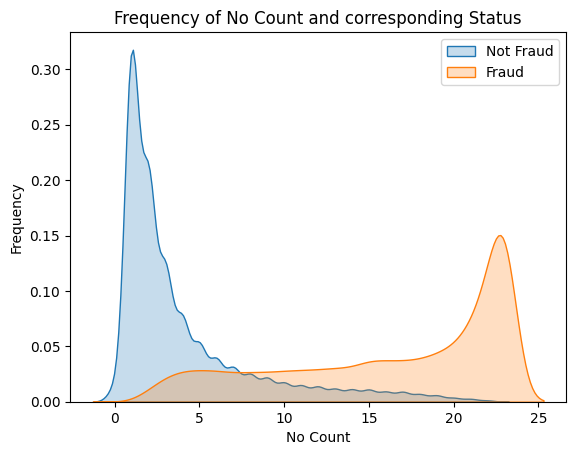

In [7]:
plot = sns.kdeplot(df["NotCount"][(df["Status"] == 0)], fill = True)
plot = sns.kdeplot(df["NotCount"][(df["Status"] == 1)], fill = True)
plot.set_xlabel("No Count")
plot.set_ylabel("Frequency")
plot.set_title("Frequency of No Count and corresponding Status")
plot.legend(["Not Fraud", "Fraud"])
plt.show()

In [8]:
#now we define the costs required for cost sensitive logistic regression
fnc = np.array(df["FNC"])
dim = (len(fnc), 1)
fnc = fnc.reshape(dim[0], dim[1])
tpc = np.array([4]*len(fnc)).reshape(dim[0], dim[1])
fpc = np.array([4]*len(fnc)).reshape(dim[0], dim[1])
tnc = np.array([0]*len(fnc)).reshape(dim[0], dim[1])

In [9]:
X = df.iloc[:, :-2].to_numpy()
y = df.iloc[:, -2:-1].to_numpy()

#since we are using tensor, we convert our numpy array data to tensor form
X = torch.FloatTensor(X)
y = torch.LongTensor(y)
fnc = torch.FloatTensor(fnc)
tpc = torch.FloatTensor(tpc)
fpc = torch.FloatTensor(fpc)
tnc = torch.FloatTensor(tnc)

In [10]:
#splitting the data into train test and loading the data
data = utils_data.TensorDataset(X, y, fnc, tpc, fpc, tnc)
split_size = [int(0.6*len(fnc)), int(0.2*len(fnc))+1, int(0.2*len(fnc))]

(train, val, test) = utils_data.random_split(data, split_size)
train_loader = utils_data.DataLoader(train, shuffle = True)
val_loader = utils_data.DataLoader(val, shuffle = False)
test_loader = utils_data.DataLoader(test, shuffle = False)

In [11]:
#we are using a sequential neural network with one linear layer and one sigmoid activation function for the logistic regressor 
#and the optimizer we are using is Adam since it is the most used and is apt for most of the cases
linear = nn.Linear(11, 1)
sigmoid = nn.Sigmoid()

network = nn.Sequential(linear, sigmoid)
optimizer = optim.Adam(network.parameters())

In [12]:
def training(train_loader, network):
  loss = []	#list to store the losses
  true = 0

  for i, (X, y, fnc, tpc, fpc, tnc) in tqdm(enumerate(train_loader)):
    optimizer.zero_grad()
    hx = network(X).squeeze(1) #finding hx
    y_hat = (hx-0.5 > 0).long()	#predictions
    
    true += (y_hat == y).item()

    loss_i = ((y*(hx*tpc+ (1-hx)*fnc))+ ((1-y)*(hx*fpc+ (1-hx)*tnc))).mean()

    loss.append(loss_i.data.item())

    loss_i.backward()
    optimizer.step()

  accuracy = true/split_size[0]
  loss = np.array(loss).mean()

  return network, accuracy, loss

In [13]:
def validating(val_loader, network):
	loss = []	#list to store the losses
	true = 0

	for i, (X, y, fnc, tpc, fpc, tnc) in tqdm(enumerate(val_loader)):
		hx = network(X).squeeze(1) #finding hx
		y_hat = (hx-0.5 > 0).long()	#predictions
		
		true += (y_hat == y).item()

		loss_i = ((y*(hx*tpc+ (1-hx)*fnc))+ ((1-y)*(hx*fpc+ (1-hx)*tnc))).mean()

		loss.append(loss_i.data.item())

	accuracy = true/split_size[1]
	loss = np.array(loss).mean()

	return network, accuracy, loss

In [14]:
#fitting the model into the neural network we created
def fitting(train_loader, val_loader, network, epochs = 7):
  train_accuracies, train_loss, val_accuracies, val_loss = [], [], [], []

  for epoch in range(0,epochs):
    print("---------------------------------------- Running at epoch ", epoch+1, " ----------------------------------------")
		#training begins here
    isTrain = 1
    network.train() #activating the neural network in training mode
    network, accuracy, loss = training(train_loader, network)

    train_loss.append(loss)
    train_accuracies.append(accuracy)
    
    # validation
    isTrain = 0
    network.eval() #activating the neural network in evaluation mode
    network, accuracy, loss = validating(val_loader, network)

    val_loss.append(loss)
    val_accuracies.append(accuracy)

  return (network, train_accuracies, train_loss, val_accuracies, val_loss)

In [15]:
#fitting the data into the neural network created
network, train_accuracies, train_loss, val_accuracies, val_loss = fitting(train_loader, val_loader, network)

---------------------------------------- Running at epoch  1  ----------------------------------------


88581it [01:42, 861.26it/s] 
29528it [00:12, 2377.78it/s]


---------------------------------------- Running at epoch  2  ----------------------------------------


88581it [01:30, 973.56it/s] 
29528it [00:11, 2465.34it/s]


---------------------------------------- Running at epoch  3  ----------------------------------------


88581it [01:29, 995.01it/s]
29528it [00:11, 2528.88it/s]


---------------------------------------- Running at epoch  4  ----------------------------------------


88581it [01:29, 988.03it/s] 
29528it [00:11, 2466.74it/s]


---------------------------------------- Running at epoch  5  ----------------------------------------


88581it [01:30, 975.72it/s]
29528it [00:11, 2557.12it/s]


---------------------------------------- Running at epoch  6  ----------------------------------------


88581it [01:28, 997.30it/s] 
29528it [00:11, 2462.84it/s]


---------------------------------------- Running at epoch  7  ----------------------------------------


88581it [01:30, 984.07it/s]
29528it [00:11, 2471.08it/s]


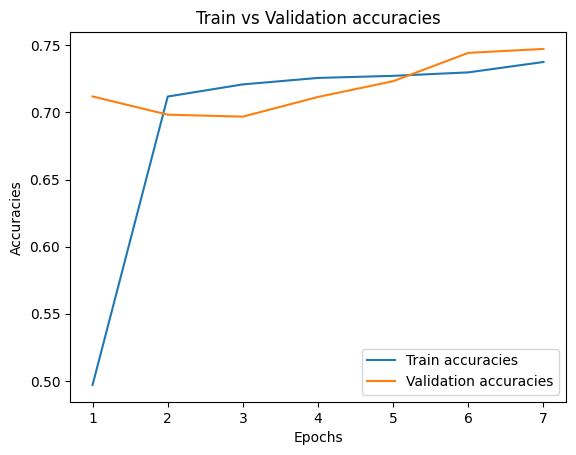

In [16]:
epochs = list(range(1, 8))

plt.plot(epochs, train_accuracies, label = "Train accuracies")
plt.plot(epochs, val_accuracies, label = "Validation accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Train vs Validation accuracies")
plt.legend()
plt.show()

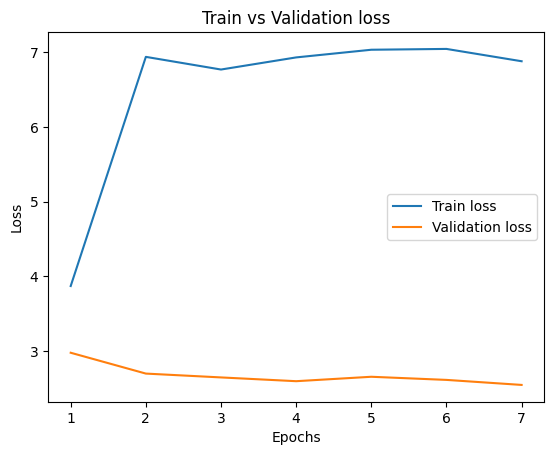

In [17]:
epochs = list(range(1, 8))

plt.plot(epochs, train_loss, label = "Train loss")
plt.plot(epochs, val_loss, label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation loss")
plt.legend()
plt.show()

In [18]:
#testing the model on test data
total, true_pos, false_pos, false_neg , correct = 0, 0, 0, 0, 0

network.eval()	#activating the obtained network after training and validating into evaluation mode

total = 0

tn, fp, fn, tp = 0, 0, 0, 0

for i, (X, y, _, _, _, _) in tqdm(enumerate(test_loader)):
	hx = network(X).squeeze(1)
	y_hat = (hx-0.5 > 0).long()

	if y.item() == 1:
		fn += (y_hat != y).sum().item()
		tp += (y_hat == y).sum().item() 
	else:
		fp += (y_hat != y).sum().item()
		tn += (y_hat == y).sum().item()

precision = tp/(tp + fp)
recall = tp/ (tp + fn)

f1 = 2*precision*recall/(precision + recall)

test_accuracy = (tp + tn)/split_size[2]

29527it [00:09, 3276.87it/s]


In [19]:
print("The results of applying Cost Sensitive Logistic Regression to the given data is:")
print("Best Train Accuracy Percentage: ", max(train_accuracies)*100, 
      "\nBest Vaidation Accuracy Percentage: ", max(val_accuracies)*100, 
      "\nTest Accuracy Percentage: ", test_accuracy*100, 
      "\nPrecision: ", precision, "\nRecall: ", recall, "\nF1 score: ", f1)

The results of applying Cost Sensitive Logistic Regression to the given data is:
Best Train Accuracy Percentage:  73.75848093835022 
Best Vaidation Accuracy Percentage:  74.73245732863722 
Test Accuracy Percentage:  74.53855793003015 
Precision:  0.5395500489077274 
Recall:  0.9476577711602336 
F1 score:  0.68760907504363
